In [1020]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [1021]:
df = pd.read_csv('data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [1022]:
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

In [1023]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [1024]:
#Standardizing features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1025]:
# Define range of C values
param_dist = {'C': np.logspace(-4, 2, 100)}
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=5, random_state=42)
random_search.fit(X_train_scaled, y_train)
log_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Grid Search with 5-fold cross-validation using ROC-AUC
grid_search = GridSearchCV(log_reg, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters
print("Best C value:", grid_search.best_params_['C'])
print("Best ROC-AUC (CV):", grid_search.best_score_)

# Plot performance vs C
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8,6))
plt.plot(results['param_C'], results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('C Value (log scale)')
plt.ylabel('Mean ROC-AUC (CV)')
plt.title('Effect of C on Model Performance')
plt.show()

# Use best C in final model
best_c = grid_search.best_params_['C']

KeyboardInterrupt: 

In [ ]:
#Logistic Regression with L1 Penalty for feature selection (Lasso Regression)
lasso_reg = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, max_iter=2000)
lasso_reg.fit(X_train_scaled, y_train)

#liblinear is used for binary classification with L1 penalty
#the C parameter is the inverse of regularization strength; smaller values specify stronger regularization (smaller = more penalty)


LogisticRegression(C=0.028117686979742307, max_iter=2000, penalty='l1',
                   solver='liblinear')

In [ ]:
# Feature selection
model_selector = SelectFromModel(lasso_reg, prefit=True)
X_train_selected = model_selector.transform(X_train_scaled)
X_test_selected = model_selector.transform(X_test_scaled)

selected_features = X.columns[model_selector.get_support()]
print("Selected features:", selected_features)
print("Number of selected features:", len(selected_features))

# We've selected 30 featured out of 95

Selected features: Index([' ROA(B) before interest and depreciation after tax',
       ' Persistent EPS in the Last Four Seasons', ' Debt ratio %',
       ' Net worth/Assets', ' Total Asset Turnover',
       ' Fixed Assets Turnover Frequency', ' Net Worth Turnover Rate (times)',
       ' Cash/Current Liability', ' Working Capital/Equity',
       ' Fixed Assets to Assets', ' Cash Flow to Equity',
       ' Current Liability to Current Assets', ' Liability-Assets Flag',
       ' Net Income to Total Assets'],
      dtype='object')
Number of selected features: 14


In [ ]:
# New selected feature dataframe

selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
selected_df.head()

,ROA(B) before interest and depreciation after tax,Persistent EPS in the Last Four Seasons,Debt ratio %,Net worth/Assets,Total Asset Turnover,Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Cash/Current Liability,Working Capital/Equity,Fixed Assets to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets
0,-0.135577,-0.216287,-1.083483,1.083483,0.010330,-0.409146,-0.300304,-0.072261,-0.161033,-0.013541,-0.137548,-0.190312,-0.030289,-0.019743
1,0.333551,0.649462,0.870610,-0.870610,2.500991,-0.409146,1.657220,-0.072261,0.429017,-0.013541,0.019307,-0.191546,-0.030289,0.508205
2,0.221065,0.074272,-0.899556,0.899556,-0.185904,-0.409146,-0.339025,-0.072261,0.048712,-0.013541,0.224626,-0.497354,-0.030289,0.530851
3,-0.519251,-0.373427,1.059554,-1.059554,0.478272,-0.409146,0.512821,-0.072261,0.378049,-0.013541,0.444912,-0.014590,-0.030289,-0.239640
4,-1.962388,-0.806301,-1.826998,1.826998,-1.318023,-0.409146,-0.764947,-0.072261,0.246063,-0.013541,-0.222198,-0.920690,-0.030289,-1.272760


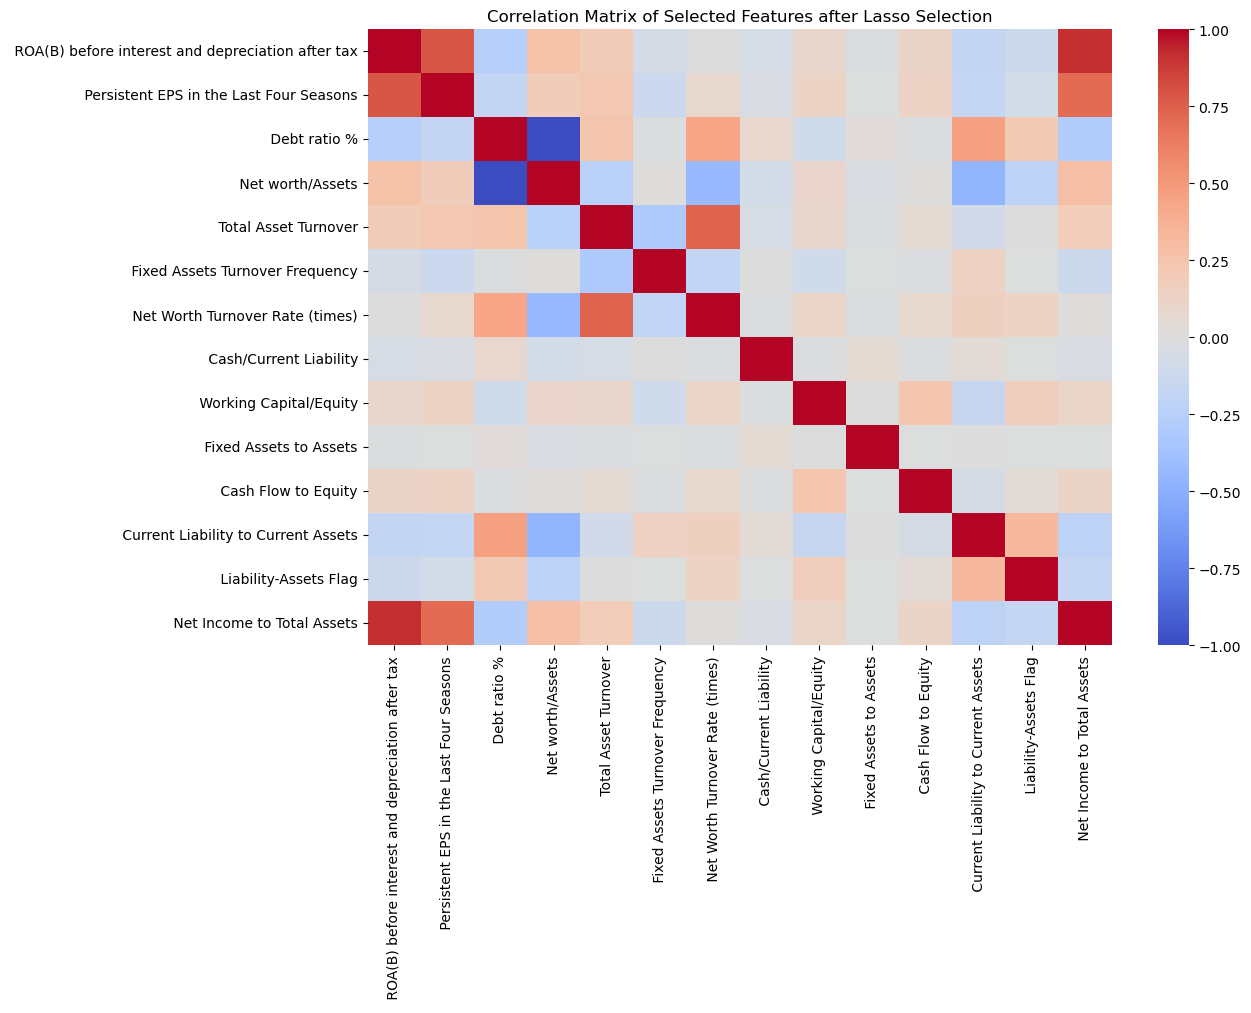

In [ ]:
# Correlation matrix with selected features
# Positive correlations mean that features move in the same direction (positively), while negative correlations mean they move in opposite directions.
corr_matrix = selected_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Selected Features after Lasso Selection")
plt.show()

In [ ]:
# Retrain with selected features
final_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_c, max_iter=2000)
final_model.fit(X_train_selected, y_train)


LogisticRegression(C=0.028117686979742307, max_iter=2000, penalty='l1',
                   solver='liblinear')

C:\Users\Aidan\AppData\Local\Temp\ipykernel_20256\1932145232.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')


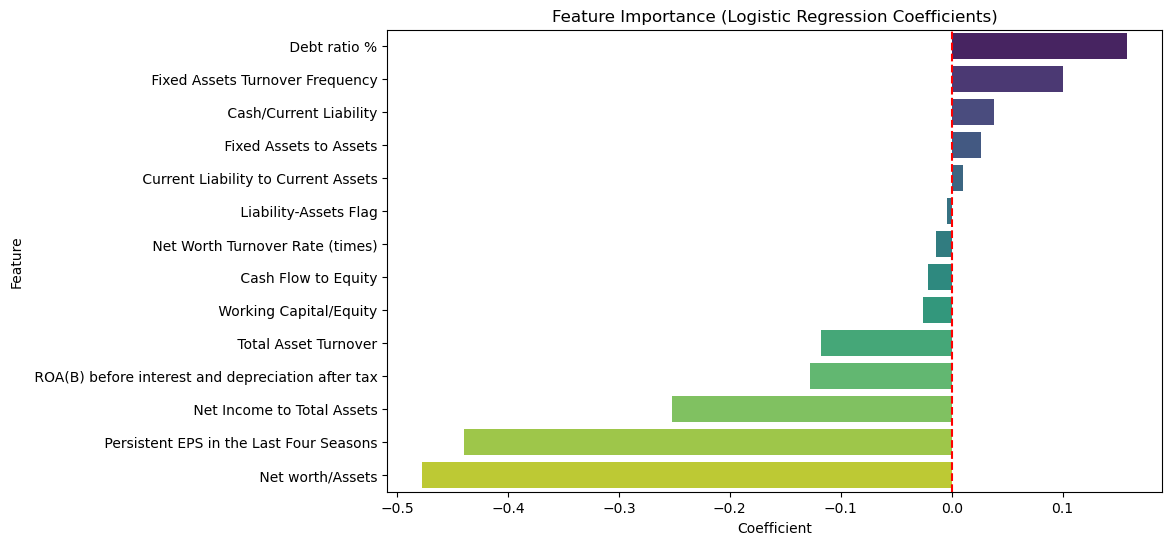

In [ ]:
#Feature importance visualization
# Positive influences bankruptcy risk, negative reduces it
coef = final_model.coef_[0]
coef_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='viridis')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.axvline(0, color='red', linestyle='--')
plt.show()

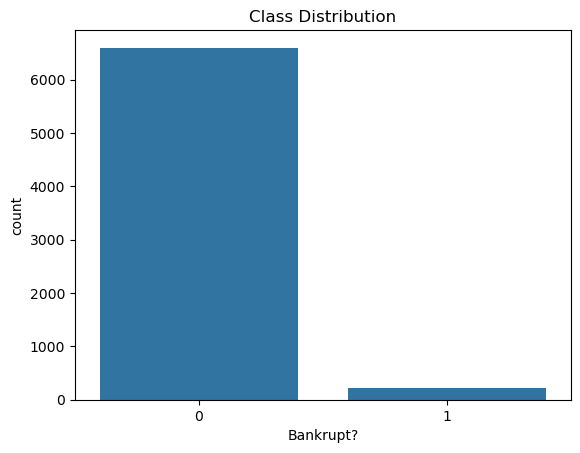

In [ ]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

The data set is extremely imbalanced so doing a simple accuracy test might not suffice.

In [ ]:
# Predictions & Evaluation
y_pred = final_model.predict(X_test_selected)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.968475073313783

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.56      0.11      0.19        44

    accuracy                           0.97      1364
   macro avg       0.76      0.56      0.59      1364
weighted avg       0.96      0.97      0.96      1364



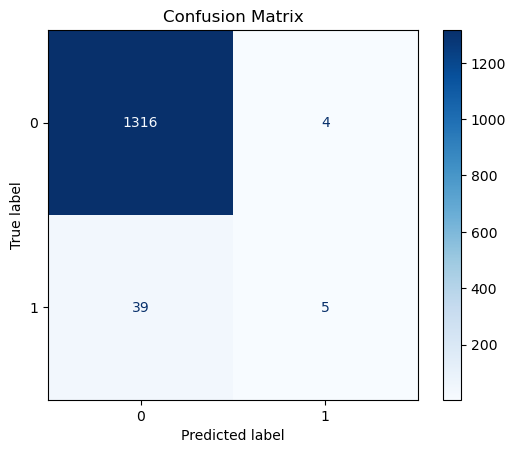

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 1318 True Positives
# 4 False Positives
# 40 False Negatives
# 4 True Negatives

In [ ]:
bankrupt_count = sum(y_test)
non_bankrupt_count = len(y_test) - bankrupt_count

print(f"Number of bankrupt companies in test set: {bankrupt_count}")
print(f"Number of non-bankrupt companies in test set: {non_bankrupt_count}")
print(f"Total samples in test set: {len(y_test)}")

Number of bankrupt companies in test set: 44
Number of non-bankrupt companies in test set: 1320
Total samples in test set: 1364


There's only 44 bankrupt companies. The model misclassified 40 of them and classified them as a healthy company instead.

AUC Score on Test Set: 0.9358


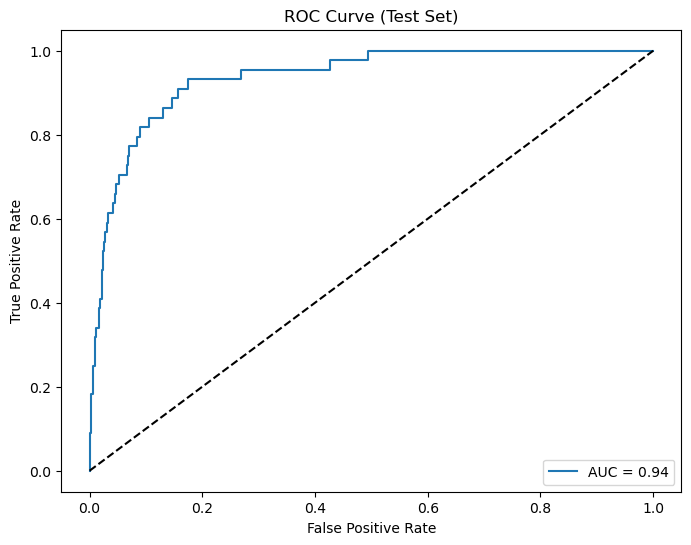

In [ ]:
# ROC Curve and AUC Score

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = final_model.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"AUC Score on Test Set: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()